In [104]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import random

In [105]:
def si_model_updated(G, initial_infected, steps, step_size):
    """
    SI model with dynamic probabilities using edge probabilities and cumulative interactions.

    Parameters:
    G: networkx.Graph
        The multilayer graph with 'probability' attributes on edges.
    initial_infected: list
        List of initially infected nodes.
    steps: int
        Number of time steps.
    step_size: int
        Number of days per step (e.g., 30 days = 1 month).

    Returns:
    susceptible_counts, infected_counts: lists
        Counts of susceptible and infected individuals at each time step.
    """
    # Initialize states
    infected = set(initial_infected)
    susceptible = set(G.nodes()) - infected

    # Track counts
    susceptible_counts = [len(susceptible)]
    infected_counts = [len(infected)]

    # Interaction rates per day (for dynamic calculation)
    per_day = 1

    for step in range(steps):
        # Calculate cumulative interaction multipliers
        per_stepsize = step_size * per_day

        # Dynamic probabilities for the current time step
        new_infected = set()

        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible:
                    # Get edge data
                    edge_data = G.get_edge_data(node, neighbor)
                    base_probability = edge_data.get('probability', 0)  # Use edge 'probability'

                    # Adjust probability based on interaction type
                    dynamic_beta = 1 - (1 - base_probability) ** per_stepsize

                    # Infection attempt
                    if np.random.rand() < dynamic_beta:
                        new_infected.add(neighbor)

        # Update states
        infected |= new_infected
        susceptible -= new_infected

        # Track counts
        susceptible_counts.append(len(susceptible))
        infected_counts.append(len(infected))

    # Normalize
    total_population = len(G.nodes())
    susceptible_counts = [(count / total_population) * 100 for count in susceptible_counts]
    infected_counts = [(count / total_population) * 100 for count in infected_counts]

    return susceptible_counts, infected_counts

In [106]:
G_no1 = nx.read_graphml("G_no1.graphml")
G_no2 = nx.read_graphml("G_no2.graphml")
G_no3 = nx.read_graphml("G_no3.graphml")
G_no4 = nx.read_graphml("G_no4.graphml")
B = nx.read_graphml("B.graphml") 

# SI With Excluding Tie-Types

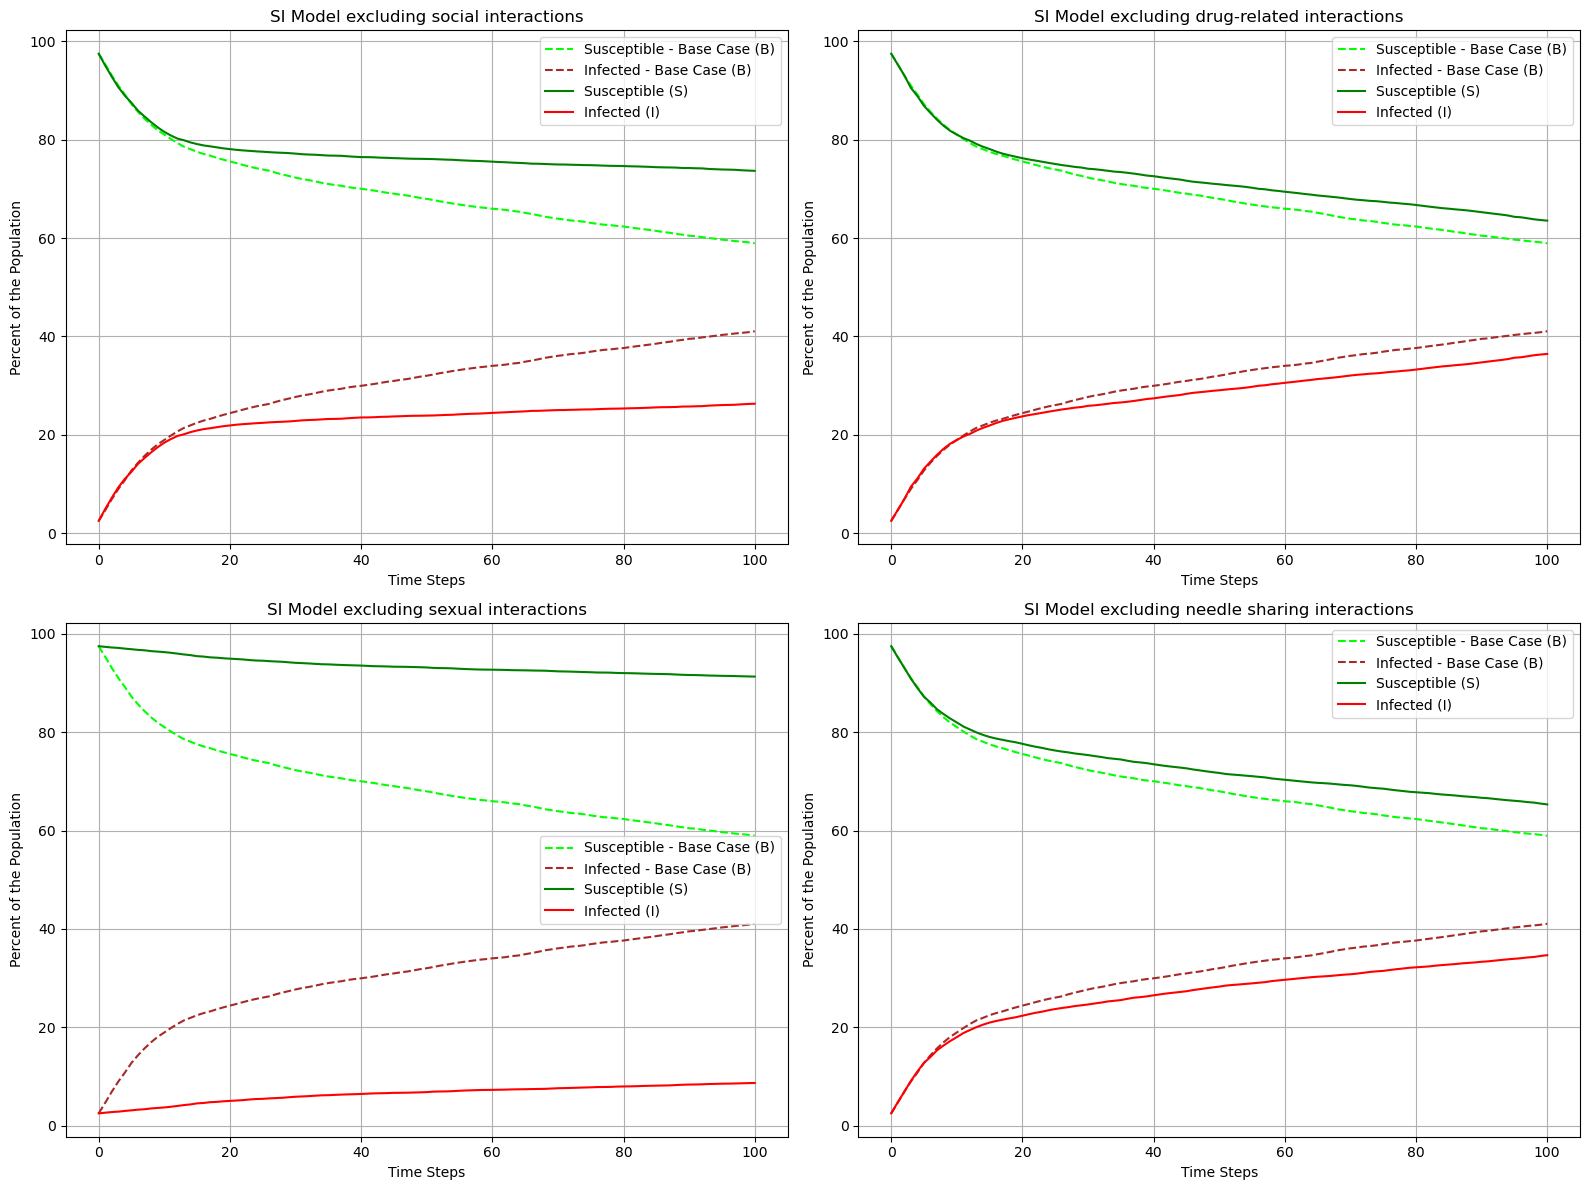

In [107]:
# Base case graph `B` for comparison
initial_infected_B = [
    node for node, attrs in B.nodes(data=True)
    if attrs.get('HIV_status', '').lower() == 'positive'
]

# Parameters
steps = 100
step_size = 30  # 1 month = 30 days

# Run SI model for the base case
susceptible_counts_base, infected_counts_base = si_model_updated(B, initial_infected_B, steps, step_size)

# Your predefined graphs
networks = [G_no1, G_no2, G_no3, G_no4]
network_titles = ["social", "drug-related", "sexual", "needle sharing"]



# Initialize a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop over each network and plot
for i, (G, ax) in enumerate(zip(networks, axes)):
    # Total population size
    total_population = G.number_of_nodes()
    
    # Initial infected nodes
    initial_infected = [
        node for node, attrs in G.nodes(data=True)
        if attrs.get('HIV_status', '').lower() == 'positive'
    ]
    
    # Run the SI model for the current graph
    susceptible_counts, infected_counts = si_model_updated(
        G, initial_infected, steps, step_size
    )
    
    # Plot base case from `B`
    ax.plot(
        range(steps + 1),
        susceptible_counts_base,
        label="Susceptible - Base Case (B)",
        color="lime",
        linestyle="--",
    )
    ax.plot(
        range(steps + 1),
        infected_counts_base,
        label="Infected - Base Case (B)",
        color="brown",
        linestyle="--",
    )
    
    # Plot current graph results
    ax.plot(range(steps + 1), susceptible_counts, label="Susceptible (S)", color="green")
    ax.plot(range(steps + 1), infected_counts, label="Infected (I)", color="red")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Percent of the Population")
    ax.set_title(f"SI Model excluding {network_titles[i]} interactions")
    ax.legend()
    ax.grid()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# PrEP Plots


## High degree


106


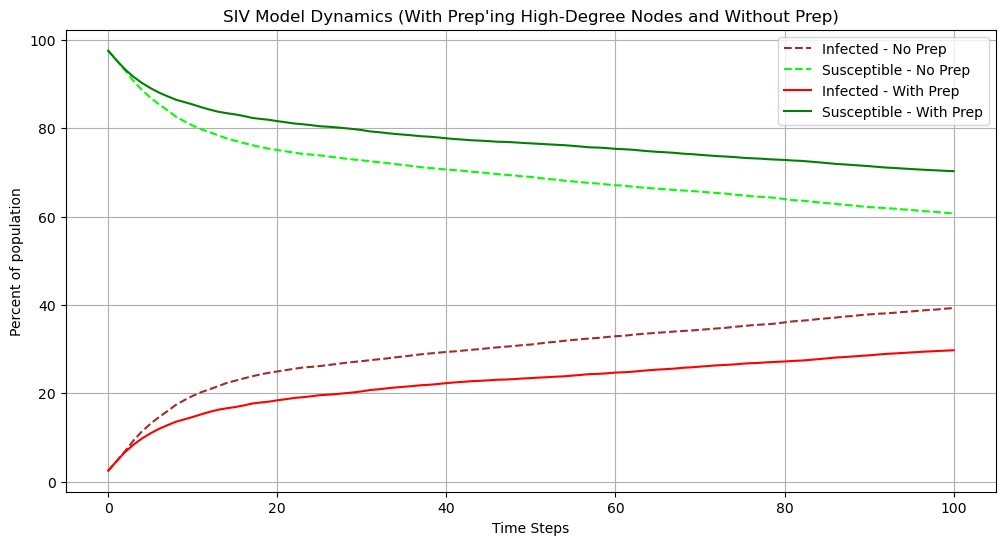

In [108]:
non_infected_node_degrees = {node: B.degree(node) for node in B.nodes() if node not in initial_infected}
sorted_non_infected_node_degrees = sorted(non_infected_node_degrees.items(), key=lambda x: x[1], reverse=True)

top_N = int(len(non_infected_node_degrees)*0.01) # Adjust this value as needed
print(top_N)


prep_nodes = [node for node, _ in sorted_non_infected_node_degrees[:top_N]]

# Prep the selected nodes (set edge probabilities to 0 for their connections)
B_prep = B.copy() 
for node in prep_nodes:
    for neighbor in list(B.neighbors(node)):
        B_prep[node][neighbor]["probability"] = 0

#Run the SI model with Prep and without
susceptible_counts_vax, infected_counts_vax = si_model_updated(B_prep, initial_infected, steps, step_size)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Plot the results (SIV comparison)
plt.figure(figsize=(12, 6))

# No vaccination
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# With Prep
plt.plot(
    range(steps + 1),
    infected_counts_vax,
    label="Infected - With Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_vax,
    label="Susceptible - With Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SIV Model Dynamics (With Prep'ing High-Degree Nodes and Without Prep)")
plt.legend()
plt.grid()
plt.show()

## Random PrEP

Number of not infected:  10605


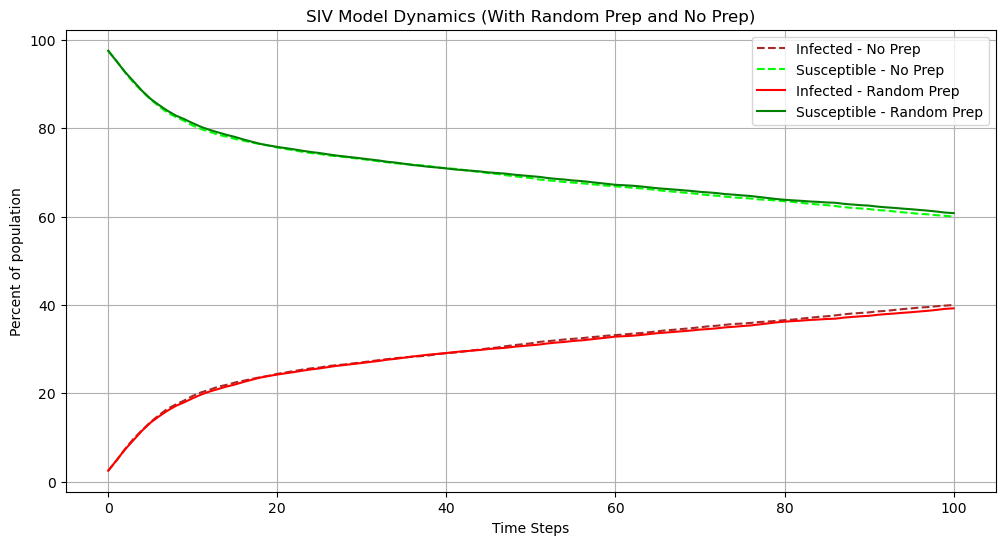

In [109]:
# Step 3: Run the SI model without Prep (original scenario)


susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Step 4: Randomly vaccinate 25 nodes on a copy of the graph with a fixed seed
random.seed(42)  # Set the seed for reproducibility

non_infected_nodes = [
    node for node, attrs in B.nodes(data=True)
    if attrs.get('HIV_status', '').lower() != 'positive'
]
print("Number of not infected: ", len(non_infected_nodes))
random_prep_nodes = random.sample(non_infected_nodes, top_N)

# Vaccinate the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_prep = B.copy()

for node in random_prep_nodes:
    for neighbor in list(B_random_prep.neighbors(node)):
        B_random_prep[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_random_vax, infected_counts_random_vax = si_model_updated(
    B_random_prep, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_random_vax,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_random_vax,
    label="Susceptible - Random Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SIV Model Dynamics (With Random Prep and No Prep)")
plt.legend()
plt.grid()
plt.show()

# Output the randomly vaccinated nodes for verification
#print("Randomly Vaccinated Nodes:", random_vaccinated_nodes)

## PrEP Friend

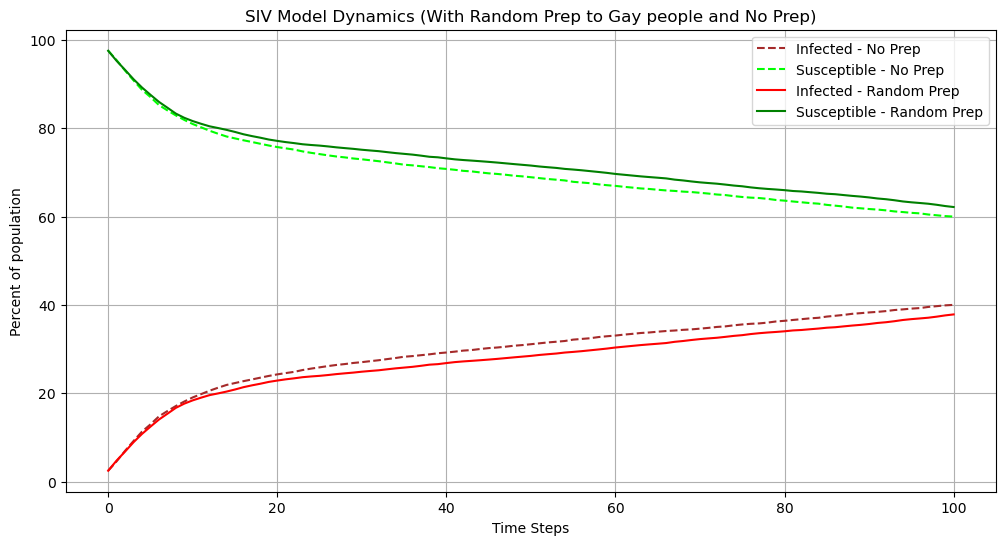

In [110]:
# Step 3: Run the SI model without Prep (original scenario)
susceptible_counts_no_vax, infected_counts_no_vax = si_model_updated(B, initial_infected, steps, step_size)

# Step 4: Randomly vaccinate 25 nodes on a copy of the graph with a fixed seed
random.seed(42)  # Set the seed for reproducibility
gay_people_without_hiv = []
for node_id, attributes in B.nodes(data=True):
    if attributes.get('HIV_status') != 'Positive' and attributes.get('Gay') == 1:
        gay_people_without_hiv.append(node_id)

random_gay_prep_nodes = random.sample(gay_people_without_hiv, top_N)

# Treat the selected nodes (set edge probabilities to 0 for their connections on a copy of the graph)
B_random_prep_gay = B.copy()

for node in random_gay_prep_nodes:
    for neighbor in list(B_random_prep_gay.neighbors(node)):
        B_random_prep_gay[node][neighbor]["probability"] = 0

# Step 5: Run the SI model with random Prep
susceptible_counts_random_vax, infected_counts_random_vax = si_model_updated(
    B_random_prep_gay, initial_infected, steps, step_size
)

# Step 6: Plot the results (SIV comparison with random Prep)
plt.figure(figsize=(12, 6))

# No Prep
plt.plot(
    range(steps + 1),
    infected_counts_no_vax,
    label="Infected - No Prep",
    color="brown",
    linestyle="--",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_no_vax,
    label="Susceptible - No Prep",
    color="lime",
    linestyle="--",
)

# Random Prep
plt.plot(
    range(steps + 1),
    infected_counts_random_vax,
    label="Infected - Random Prep",
    color="red",
    linestyle="-",
)
plt.plot(
    range(steps + 1),
    susceptible_counts_random_vax,
    label="Susceptible - Random Prep",
    color="green",
    linestyle="-",
)

plt.xlabel("Time Steps")
plt.ylabel("Percent of population")
plt.title("SIV Model Dynamics (With Random Prep to Gay people and No Prep)")
plt.legend()
plt.grid()
plt.show()

# Output the randomly vaccinated nodes for verification
# print("Randomly Vaccinated Nodes:", random_vaccinated_nodes)